# Tutorial 1

In this first tutorial we build up an example where a robot needs to track an externally generated trajectory.

We start by importing the numpy library for matrix computations in python:

In [1]:
import numpy as np

The following is a little trick to change the width of the notebook.

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; } </style>"))

Import all needed objects and functions from etasl_py.etasl and start up the simulator object:

In [3]:
from etasl_py.etasl import etasl_simulator,array_to_dict,dict_to_array,to_deg, to_rad
e = etasl_simulator(regularization_factor= 0.00001)

The tuning options for the etasl_simulator class are:

    def __init__(self, 
                    nWSR                  = 300,
                    cputime               = 1000,
                    regularization_factor = 1E-4
                ):
        creates an etasl_simulator object

        input parameters:
            nMWSR :  number of iterations of the underlying QP-solver
            cputime: maximum CPU time to spend on solver one time-step
            regularization_factor :  regularization to be used during the
                                     optimization.  The weight of the joint/feature
                                     variable velocities compared to the weight of the
                                     constraints.

You can get documentation by typing `etasl_simulator?`

### Define the robot
Use the urdf file robots/ur10_robot.urdf from the etasl_py_examples package to define a robot in eTaSL.  Define the lists **robot_jname** with the joint names and **robot_jval** with expressions for the joint values.  

You can use ```roslaunch etasl_py_examples gui_ur10.launch``` to visualize the robot, its joint values and its frames.

Or you can use a graph generated from the urdf file, as follows.  The square boxes indicate the rigid bodies, the ellipsoides indicate joints (which can be moving joints or fixed joints).  We can generate expressions for the transformation between two rigid bodies.  We first specify all the expressions we need, and then we ask to generate all these expressions together.  In this way, the system can generate expressions that optimally reuse the computations between all the requested transformations.

Created file ur10.gv
Created file ur10.pdf


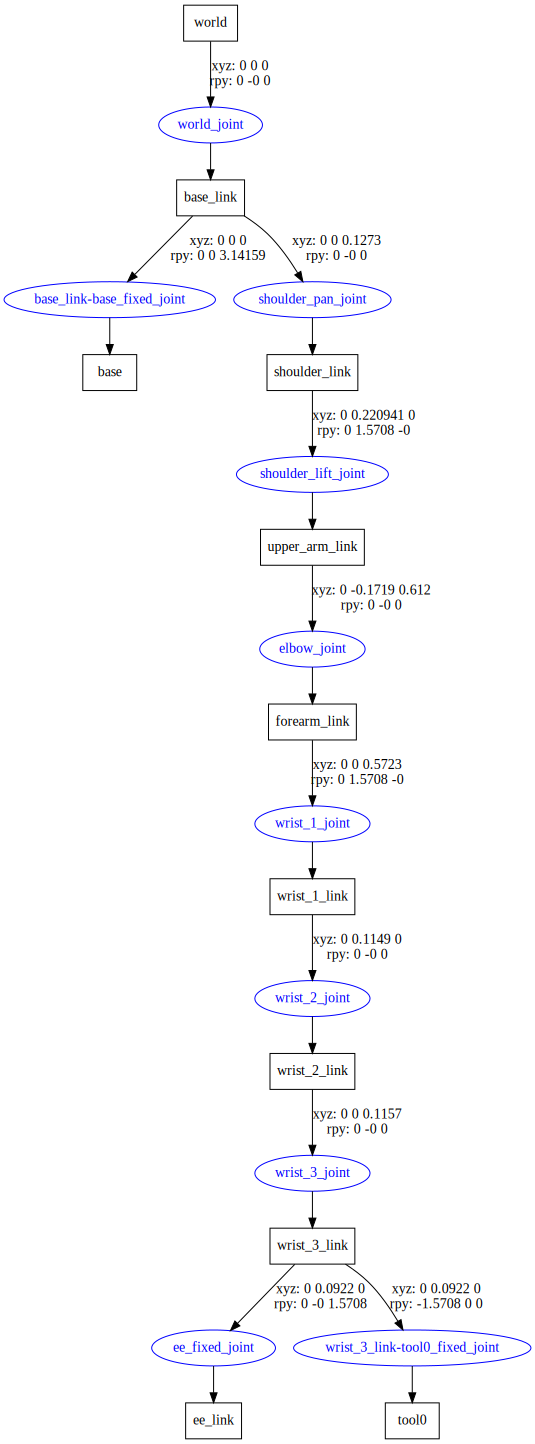

In [4]:
!urdf_to_graphiz $(rospack find etasl_py_examples)/robots/ur10_robot.urdf
from graphviz import Source
Source.from_file('ur10.gv')

Define ee as the expression of tool0 wrt base_link. You can use roslaunch etasl_py_examples gui_ur10.launch to visualize the robot, its joint values and its frames.

Using this graph we define **ee** as the expression of tool0 wrt base_link.  We also define a fixed order for the robot joints (that should have names that correspond to the urdf file), and the joint values. We store the names in **robot_jname** and expressions for the joints in **robot_jval**.

We use the **readTaskSpecification** method to read in a (partial) eTaSL definition.  You can call **readTaskSpecificationString** (and readTaskSpecificationFile) multiple times to read in a complete eTaSL definition in pieces. (separating e.g. the robot definition from the task definition).

In [5]:
e.readTaskSpecificationString("""
    require("context")
    require("geometric")
    local u=UrdfExpr();
    local fn = rospack_find("etasl_py_examples").."/robots/ur10_robot.urdf"
    u:readFromFile(fn)
    u:addTransform("ee","tool0","base_link")
    local r = u:getExpressions(ctx)
    ee = r.ee
    robot_jname={"shoulder_pan_joint","shoulder_lift_joint","elbow_joint","wrist_1_joint","wrist_2_joint","wrist_3_joint"}
    robot_jval = {}
    for i=1,#robot_jname do
       robot_jval[i]   = ctx:getScalarExpr(robot_jname[i])
    end
""")

The following is a simple eTaSL specification that declares three **input channels**, applies **constraints** such that the end effector of the robot follows the input, and declares three **output expressions** corresponding to the end effector origin.  The input channels declare inputs in eTaSL. With the **eTaSL python** driver (used in this notebook) these can be connected to e.g. an input table of values.  With the **eTaSL RTT** driver (Orocos), you can connect these input channels to input ports of the eTaSL component.  Input channels are typically used to take in a desired trajectory or to get sensor values inside eTaSL.
You can also declare an expression as an output expressions.  The value for these expressions can then be accessed outside eTaSL ( table of values for the python driver, output ports of the component for eTaSL RTT ).

The constraints in the example below state that the origin of the end effector frame **ee** should track the input **tgt_x**, **tgt_y**, **tgt_z**.  It will behave as a first order system, with time constant $\frac{1}{K}$, $K$ is expressed in $[s^{-1}]$. It is a **soft** constraint, so deviations are allowed and are weighted.  The weights are not specified here, so they have their default value $1$.

**IMPORTANT WARNING**

The terms *hard* and *soft* should be interpreted at the *velocity* level (with the current eTaSL velocity-resolved solver).  

So a *hard* constraint is a constraint that still can deviate at the position-level, but the velocity needed to corrected this position error should be achieved perfectly.  A hard constraint will achieve his position target as a first order system with the given time constant.

With a *soft* constraint, the system will generate a velocity as close as possible to the velocity needed to have a first order evolution towards the target value.  However, due to e.g. conflicting constraints, this velocity is not always reached.  In case of a conflicting constraints acting upon the same frame or point, this results in a first order evolution towards a weighted average:
\begin{equation}
    \frac{W_1}{W_1+W_2} tgt_1 + \frac{W_1}{W_1+W_2} tgt_2.
\end{equation}

Soft constraints have a weight, hard constraints do not have a weight.  Within eTaSL, soft constraints are specified as ```priority = 2```, hard constraints have ```priority==0```.



In [6]:
e.readTaskSpecificationString("""
    tgt_x = ctx:createInputChannelScalar("tgt_x",0.7)
    tgt_y = ctx:createInputChannelScalar("tgt_y",0)
    tgt_z = ctx:createInputChannelScalar("tgt_z",0.7)

    Constraint{
        context=ctx,
        name="x",
        expr = tgt_x - coord_x(origin(ee)),
        priority = 2,
        K        = 4
    }
    Constraint{
        context=ctx,
        name="y",
        expr = tgt_y - coord_y(origin(ee)),
        priority = 2,
        K        = 4
    }
    Constraint{
        context=ctx,
        name="z",
        expr = tgt_z - coord_z(origin(ee)),
        priority = 2,
        K        = 4
    }

    ctx:setOutputExpression("error_x",coord_x(origin(ee))-tgt_x)
    ctx:setOutputExpression("error_y",coord_y(origin(ee))-tgt_y)
    ctx:setOutputExpression("error_z",coord_z(origin(ee))-tgt_z)
""")

The following displays a summary of the contents of the **context** (ctx). Note that besides the x, y and z constraints specified above, other constraints are defined by the URDF specification: hard position lower and upper limits and maximum/minimum velocity limits. 

If possible we try to avoid that our robot arrives at these **hard** limits since they take away degrees of freedom and could cause a (near) singularity of the robot. We prefer that our constraints are **tracking** constraints, i.e. that they do not deviate much; otherwise, if the deviation is large, the velocities to correct the errors are very high and will hit the limits of the robot.

In [7]:
e.displayContext()

For the curious, you can visualize the underlying expressiongraphs as follows. First it is generated within eTaSL and written to a file 't.dot'.  Then it is visualized in the notebook using the graphviz library. As you can see the expressiongraphs for the error_x and error_y share a big part of the graph.

In [8]:
e.readTaskSpecificationString("write_expressions_to_dot('t.dot',{error_x = coord_x(origin(ee))-tgt_x, error_y=coord_y(origin(ee))-tgt_y })")


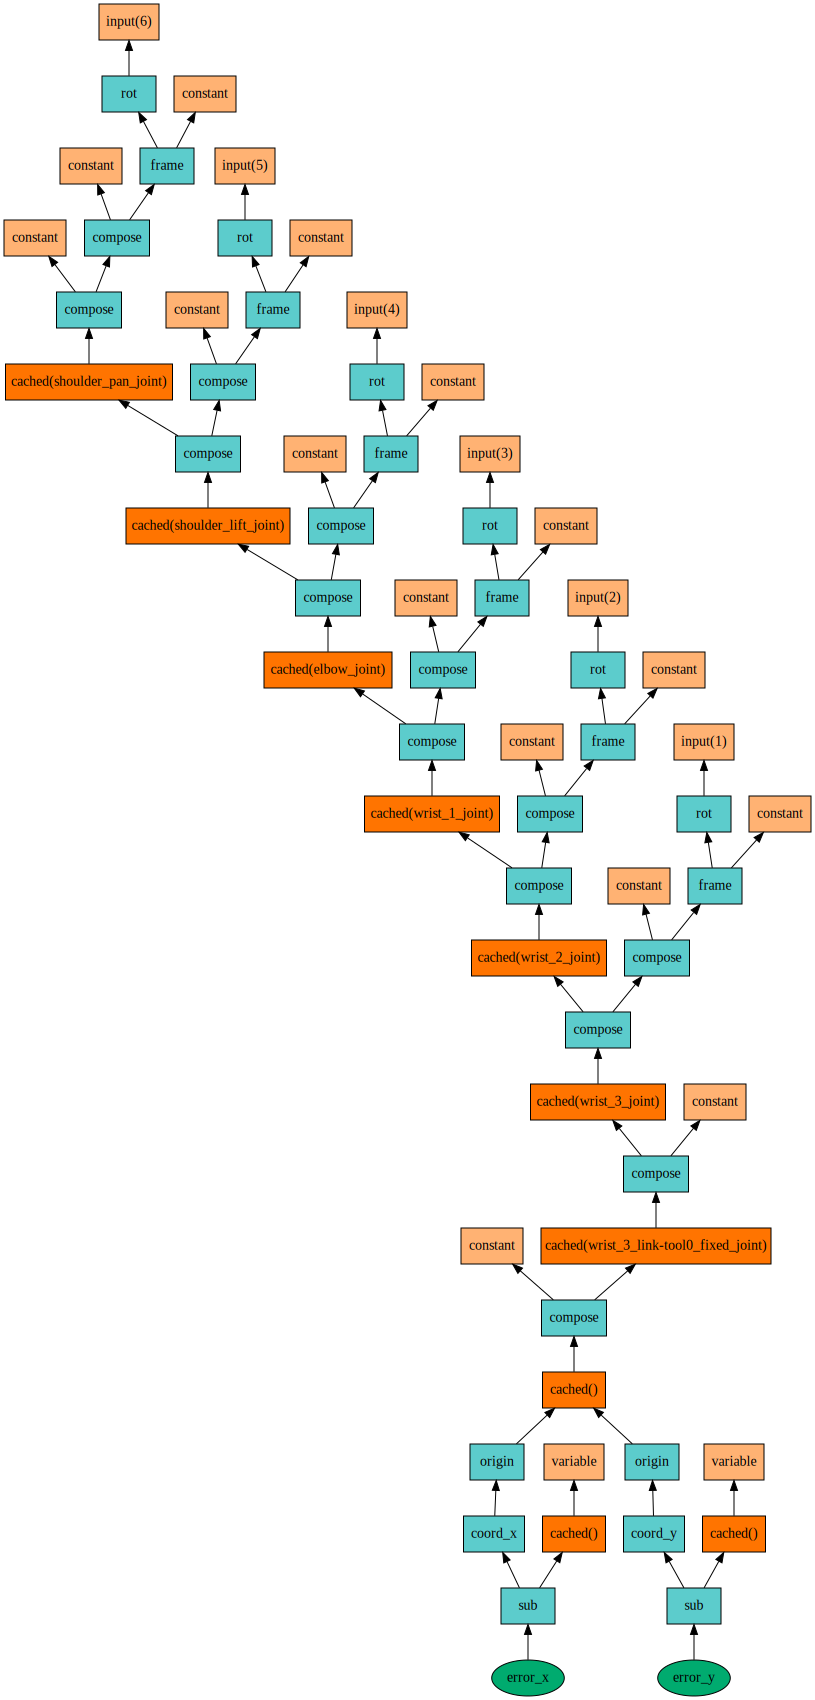

In [9]:
from graphviz import Source
Source.from_file('t.dot')

Note that the structure of this expressiongraph is different from a scenegraph (as described by the urdf file for the robot) (see above).

Our simulated robot should start from a specified position.  We should also specify our prefered order for the joints in the output tables and plots, and give appropriate labels (corresponding to the eTaSL specification) to the joints.

In [ ]:
pos_lbl = ['shoulder_pan_joint','shoulder_lift_joint', 'elbow_joint', 
           'wrist_1_joint', 'wrist_2_joint',  'wrist_3_joint']
initial_jpos = np.array([0, -np.pi*0.6 , np.pi*0.6,0,0,0])

We want to simulate $N=4000$ steps of a sample period $dt=0.005$ (200Hz):

In [ ]:
N=4000
dt=0.005

With this information we can define our input signals.  We can specify both the value and the derivative for our input signals.  Again we also need to specify the labels.

In [ ]:
time = np.arange(0,N)*dt
inp_lbl=['tgt_x','tgt_y','tgt_z']
inp=np.zeros((N, len(inp_lbl)))
inp[:,0] = np.sin(time)*0.15 + 0.7
inp[:,1] = time*0
inp[:,2] = time*0 + 0.3
inpvel = np.zeros((N, len(inp_lbl)))
inpvel[:,0] = np.cos(time)*0.15
inpvel[:,1] = time*0
inpvel[:,2] = time*0
e.setInputTable(inp_lbl,inp,inpvel)

We can then initialize the eTaSL specification, i.e. determine the appropriate starting values for the feature variables in the presence of hard constraints.  The following is an extract from the documentation:

    def initialize(self,initialval, initial_lbl, max_time, time_step, convergence_crit):

     Initializes the controller and performs an optimization to compute an optimal start value 
     for the feature variables.

     Performs the following tasks in this order:
        1) prepares the solver for the initialization problem
        2) initializes the state (robot/feature names, values and velocities)
        3) sets the initial value for robot/feature variables 
        4) performs an optimization to compute an optimal start value 
           for the feature variables (only taking into account the constraints with priority==0)
        5) prepares the solver for the exuction problem and solves one step
           (such that next steps are all hot-starts)

     Args:
        initialval:           value of robot- and feature variables you 
                              want to initialize (before initialization optimization)
                              (if not specified, the initial value of the specification
                               is used.)
        initial_lbl:          labels belonging the initial value array.
        initialization_time:  max. (virtual) time to use for initialization
        sample_time:          (virtual) sample time to use for the initialization
        convergence_crit:     convergence criterion used to stop the initialization early.
    Warning:
        - initializes time to 0, you can overwrite this in the initialval map.
        - robot variables remain identical as specified after this method call.
        - feature variables can be changed after this method call (if they are involved
          in the initialization optimization). 

     Returns:
        convergedval:         variable to return the converged values for joint and 
                              feature variables. 

         TaskSpecificationException, NumericalException, LogicalException

As can be seen there are a few additional parameters `initialization_time`, `sample_time`, and `convergence_time` that are used during the initialization process.

In [ ]:
e.initialize(initial_jpos, pos_lbl)

Finally we can simulate the eTaSL specification with the given $N$ and $dt$:

In [ ]:
e.simulate(N=N,dt=dt)

The following member variables are now available on the simulator object $e$:
 - INP : input signals
 - INPVEL : partial time derivative of the input signals (optional)
 - INP_LBL : labels for the columns of INP & INPVEL, should correspond to eTaSL specification (input channels)
 - OUTP : outputs of the simulation
 - OUTP_LBL : labels for the outputs of the simulation, should correspond to the eTaSL specification (output expressions).
 - POS : position values for joint variables and feature variables.
 - VEL : velocity values for joint variables and feature variables.
 - POS_LBL : labels for the joint and feature variables.
 - TIME : time vector
 

# Plotting (using the Bokeh library to provide interactive plots)

In [ ]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import gridplot
from etasl_py.bokehplots import plotv

output_notebook()
print("positions : ")
plotv(e.TIME,e.POS,e.POS_LBL)
print("velocities : ")
plotv(e.TIME,e.VEL,e.POS_LBL)
print("outputs : ")
plotv(e.TIME,e.OUTP,e.OUTP_LBL)

We we look closer at the evolution of the tracking error, we see that it indeed evolves as a first order system with time constant $0.25 = \frac{1}{K}$:

![time constant 0.25](img/analysis_timeconstant.png)
